# GraphSHAPer implementation

Explain the graph classification using Shaply values for edges.
Determine the contribution of each edge towards the output value (predicted problability)

Starting point:

TODO:

* Method 1 (jackknife-style sampling): compute approx shapley value for edge $e$ considering all possibile coalitions of $E - 1$ edges, where $E$ is the number of edges.
* Method 2 (montecarlo sampling)
* Method 3 (exahustive search)
* Method 4 (node sampling): sample a number of nodes and work in the nodes k-hop subgraph similarly to a node classification explanation 

In [1]:
import torch
from torchdrug import data
import pandas as pd
import numpy as np
import random

from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
# for debugging
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

## Reprodicubility Settings

In [3]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

## Data Loading

In [17]:
DATASET_TYPE = "single" #"single", dual
MODEL_NUM = 2
TARGET_CPDS = "P14416_P42336"
DATASET_NAME = "chembl29_predicting_target_" + TARGET_CPDS + "_target_1_vs_random_cpds" # "chembl29_dt_cpds_" + TARGET_CPDS + "_balanced" #"chembl29_predicting_target_P14416_P42336_target_1_vs_random_cpds"
CSV_DATA_PATH = "../data/"+ DATASET_NAME + ".csv"

smiles_df = pd.read_csv(CSV_DATA_PATH, sep = ",")
display(smiles_df.head())
display(smiles_df.shape)

,nonstereo_aromatic_smiles,target_pair,label
0,Brc1ccc(CNCCN2CCN(Cc3cc4ccccc4[nH]3)CC2)cc1,P14416_P42336,0
1,Brc1ccc(N2CCN(Cc3ccccc3)CC2)c2cc[nH]c12,P14416_P42336,0
2,Brc1ccc(NCCN2CCN(CCc3c[nH]c4ccccc34)CC2)cc1,P14416_P42336,0
3,Brc1ccc(NCCN2CCN(Cc3cc4ccccc4[nH]3)CC2)cc1,P14416_P42336,0
4,Brc1cccc(N2CCN(Cc3cc4ccccn4n3)CC2)n1,P14416_P42336,0


(8348, 3)

## Define Custom Class
We need to define the ChEMBL datasets class in order to load the model

In [5]:
import os

from torchdrug.core import Registry as R
from torchdrug.utils import doc


@R.register("datasets.ChEMBL") #only first time you launch the class
#@doc.copy_args(data.MoleculeDataset.load_csv, ignore=("path", "smiles_field", "target_fields"))
class ChEMBL(data.MoleculeDataset):
    

    def __init__(self, path, smiles_field, target_fields, verbose=1, **kwargs):
        # path = os.path.expanduser(path)# if not os.path.exists(path):
        #     os.makedirs(path)
        self.path = path
        self.smiles_field = smiles_field
        self.target_fields= target_fields
        #print(self.path)
        # zip_file = utils.download(self.url, path, md5=self.md5)
        # csv_file = utils.extract(zip_file)

        self.load_csv(self.path, smiles_field=self.smiles_field, target_fields=self.target_fields,
                      verbose=verbose, **kwargs)

In [6]:
#target_fields = ["target1", "target2"] if DATASET_TYPE == "dual" else ["label"]
target_fields = ["label"]
chembl_dataset = ChEMBL(path = CSV_DATA_PATH, smiles_field = "nonstereo_aromatic_smiles", target_fields = target_fields)

Loading ../data/chembl29_predicting_target_P14416_P42336_target_1_vs_random_cpds.csv: 100%|██████████| 8349/8349 [00:00<00:00, 36663.17it/s]
Constructing molecules from SMILES:  54%|█████▍    | 4506/8348 [00:40<00:38, 99.88it/s] C:\Users\Mastro\anaconda3\envs\graphshap_cheminfo\lib\site-packages\torchdrug\data\feature.py:37: UserWarning: Unknown value `Na`
  warnings.warn("Unknown value `%s`" % x)
Constructing molecules from SMILES: 100%|██████████| 8348/8348 [01:24<00:00, 98.65it/s] 


## Obtain edge index to use with PyG

Visualize molecules using NetworkX

  0%|          | 0/8348 [00:00<?, ?it/s]

[(0, 'Br'), (1, 'C'), (2, 'C'), (3, 'C'), (4, 'C'), (5, 'C'), (6, 'N'), (7, 'C'), (8, 'C'), (9, 'N'), (10, 'C'), (11, 'C'), (12, 'N'), (13, 'C'), (14, 'C'), (15, 'C'), (16, 'C'), (17, 'C'), (18, 'C'), (19, 'C'), (20, 'C'), (21, 'C'), (22, 'N'), (23, 'C'), (24, 'C'), (25, 'C'), (26, 'C')]


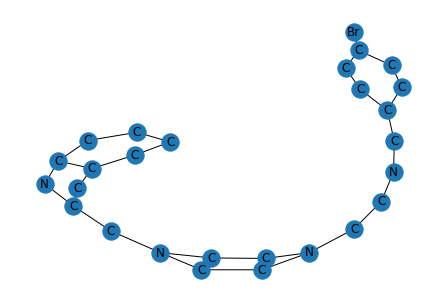

In [7]:
from pysmiles import read_smiles
import networkx as nx
    
smiles = chembl_dataset.smiles_list
mols = []
for i in tqdm(range(len(chembl_dataset.smiles_list))):
    mols.append(read_smiles(chembl_dataset.smiles_list[i]))

mol = mols[0]
print(mol.nodes(data='element'))
labels = nx.get_node_attributes(mol, 'element') 
nx.draw(mol, labels = labels, pos=nx.spring_layout(mol))

Define edge index 

In [8]:
edge_index_list = []

for mol in tqdm(mols):
    adj = nx.to_scipy_sparse_matrix(mol).tocoo()
    row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
    col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
    edge_index = torch.stack([row, col], dim=0)
    edge_index_list.append(edge_index)

display(len(mols))

  0%|          | 0/8348 [00:00<?, ?it/s]

8348

Define torchdrug dataset in order to get node features

In [9]:
mols_torchdrug_format = []
for i in tqdm(range(len(chembl_dataset.smiles_list))):
    mols_torchdrug_format.append(data.Molecule.from_smiles(chembl_dataset.smiles_list[i], with_hydrogen = False))


  0%|          | 0/8348 [00:00<?, ?it/s]

C:\Users\Mastro\anaconda3\envs\graphshap_cheminfo\lib\site-packages\torchdrug\data\feature.py:37: UserWarning: Unknown value `Na`
  warnings.warn("Unknown value `%s`" % x)


## Create Custom Dataset

In [10]:
import pandas as pd
from torch_geometric.data import InMemoryDataset, Data

from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_list = []
y = torch.LongTensor(chembl_dataset.targets["label"]).to(device)

for i in tqdm(range(len(mols))):
    data_list.append(Data(x = mols_torchdrug_format[i].node_feature, edge_index = edge_index_list[i], y = y[i], smiles = chembl_dataset.smiles_list[i]))


  0%|          | 0/8348 [00:00<?, ?it/s]

In [11]:
class ChEMBLDatasetPyG(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None, data_list = None):
        super().__init__(root, transform, pre_transform, pre_filter)
        #self.data, self.slices = torch.load(self.processed_paths[0])
        self.data_list = data_list

        # Read data into huge `Data` list.
        data_list = self.data_list

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        self.data, self.slices = self.collate(data_list)
        

In [12]:
dataset = ChEMBLDatasetPyG(".", data_list = data_list)

Split data in train/val/test (0.8/0.1/0.1)

In [13]:
lengths = [int(0.8 * len(chembl_dataset)), int(0.1 * len(chembl_dataset))]
lengths += [len(chembl_dataset) - sum(lengths)]

print(lengths)
dataset = dataset.shuffle()
train_data = dataset[:lengths[0]]
val_data = dataset[lengths[0]+1:lengths[0] + lengths[1]+1]
test_data = dataset[lengths[0] + lengths[1] : ]
len(train_data), len(val_data), len(test_data)

[6678, 834, 836]


(6678, 834, 836)

In [14]:
batch_size= 32
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

## GCN Definition

In [15]:
from torch_geometric.nn import GCNConv, Linear
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(chembl_dataset.node_feature_dim, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=256).to(device)
print(model)

GCN(
  (conv1): GCNConv(69, 256)
  (conv2): GCNConv(256, 256)
  (conv3): GCNConv(256, 256)
  (conv4): GCNConv(256, 256)
  (lin): Linear(in_features=256, out_features=2, bias=True)
)


## Load the Model

In [18]:
import os.path as osp

MODEL_PATH = "../models/PyG/" + DATASET_NAME + "_model_" + str(MODEL_NUM) + ".ckpt"
ckpt_path = osp.join(MODEL_PATH)
model.load_state_dict(torch.load(ckpt_path))
model.to(device)

GCN(
  (conv1): GCNConv(69, 256)
  (conv2): GCNConv(256, 256)
  (conv3): GCNConv(256, 256)
  (conv4): GCNConv(256, 256)
  (lin): Linear(in_features=256, out_features=2, bias=True)
)

## Test the Model

In [19]:
def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         data = data.to(device)
         
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.

test_acc = test(test_loader)    
print(f'Test Acc: {test_acc:.4f}')

####THIS IS NOT THE TEST USED BY THE LOADED MODEL, WE NEED TO BE COHERENT AND USE THE SAME TRAIN,VAL AND TEST SETS############## TODO later, the focus now in explainability

Test Acc: 0.9988


## GraphSHAPer

* Players = edges
* Value = predicted probability $v$
* $E$ = set of all edges
* $v(E)$ = value of all the edges == original predicted prob
* $\phi_m(v)$ = payout for the contribution of edge m
* $S$ = all the possible subset of edges excluding m
* |S| = size of S
* $v(S)$ is the value achieved by subset S
* $v(S∪{m})$ is the realized value after m joins S

Shapley values compouted as:

$\phi_m(v) = \frac{1}{|E|} \sum_S \frac{v(S \cup {m}) - v(S)}{\binom{|E|-1}{|S|}}$

COCOc1ccccc1OCCNCC1COCC(c2ccccc2)(c2ccccc2)O1
tensor([[ 7.3421, -7.0263]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[1.0000e+00, 5.7529e-07]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


C:\Users\Mastro\anaconda3\envs\graphshap_cheminfo\lib\site-packages\torchdrug\data\molecule.py:468: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0

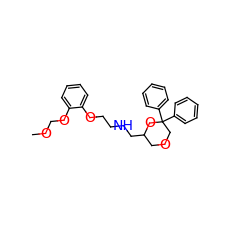

In [20]:
#test nums 78, 89 is predicted to interact with target cpd, 0 is random for single target dataset with target 1
# 78 is predicted to interact with target for dataset with target 2. 0 interacts with random
# for dual target Q9Y5N1_P31645 sample 0 has class 0
# for dual target P27338_P29274 sample 0 is class 0
# for dual targe P27338_P22303 sample 4 is class 0

test_cpd = test_data[78].to(device)
print(test_cpd.smiles)
mol_test = data.Molecule.from_smiles(test_cpd.smiles, with_hydrogen=False)
mol_test.visualize()

model.eval()
# all nodes belong to same graph
batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
out = model(test_cpd.x, test_cpd.edge_index, batch=batch)
out_prob = F.softmax(out, dim = 1)
target_class = torch.argmax(out_prob[0]).item()
print(out)
print(out_prob)
target_class

Creating folder and saving smiles

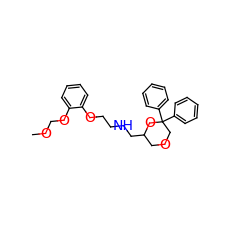

In [21]:
FOLDER_NAME = "../results/explanations/" + DATASET_TYPE + "/" + TARGET_CPDS
CPD_FOLDER_NAME = FOLDER_NAME + "/" + test_cpd.smiles

if not os.path.exists(FOLDER_NAME):
    os.mkdir(FOLDER_NAME)

if not os.path.exists(CPD_FOLDER_NAME):
    os.mkdir(CPD_FOLDER_NAME)


mol_test.visualize(save_file = CPD_FOLDER_NAME + "/" + test_cpd.smiles + ".png")

In [22]:
print(test_cpd.edge_index)
print(test_cpd.edge_index.shape)

tensor([[ 0,  1,  1,  2,  2,  3,  3,  4,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,
          9,  9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 15, 16, 16,
         17, 17, 18, 18, 19, 19, 19, 19, 20, 20, 20, 21, 21, 22, 22, 23, 23, 24,
         24, 25, 25, 26, 26, 26, 27, 27, 28, 28, 29, 29, 30, 30, 31, 31, 32, 32],
        [ 1,  0,  2,  1,  3,  2,  4,  3,  5,  9,  4,  6,  5,  7,  6,  8,  7,  9,
          4,  8, 10,  9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 14, 16, 32, 15, 17,
         16, 18, 17, 19, 18, 20, 26, 32, 19, 21, 25, 20, 22, 21, 23, 22, 24, 23,
         25, 20, 24, 19, 27, 31, 26, 28, 27, 29, 28, 30, 29, 31, 26, 30, 15, 19]],
       device='cuda:0')
torch.Size([2, 72])


### Jackknife approx

* $S = E/\{m\}$
* $ v(S \cup {m}) = v(E)$ # since if we add m back we obtain the original graph

In [23]:
from scipy.special import binom

v_E = out_prob[0][target_class].item()
E = test_cpd.edge_index
phi_edges = []
v_S_u_m = v_E

for i in tqdm(range(E.shape[1])):
    # node_source = E[0][i]
    # node_to = E[1][i]
    #S = E[0:,i:]
    S = torch.cat([E[0:,0:i], E[0:,i+1:]], dim = 1)
    batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
    out = model(test_cpd.x, S, batch=batch) #we use S as edge index
    out_prob = F.softmax(out, dim = 1)
    v_S = out_prob[0][target_class].item()

    denominator = binom(E.shape[1] - 1, 1)

    shapley_value = (1/E.shape[1]) * ((v_S_u_m - v_S) / denominator) #jackknife approximation
    phi_edges.append(shapley_value)

sum(phi_edges)


  0%|          | 0/72 [00:00<?, ?it/s]

0.0002776708436404036

In [24]:
phi_edges

[4.6639002171667157e-11,
 -6.995850325750072e-11,
 4.6639002171667157e-11,
 0.0,
 1.165975054291679e-10,
 -4.6639002171667157e-11,
 -6.995850325750072e-11,
 2.3319501085833578e-11,
 -2.3319501085833578e-11,
 9.327800434333431e-11,
 3.031535141158365e-10,
 2.3319501085833578e-11,
 2.3319501085833578e-11,
 0.0,
 0.0,
 -2.3319501085833578e-11,
 0.0,
 1.6323650760083502e-10,
 2.3319501085833578e-11,
 -2.3319501085833578e-11,
 6.296265293175066e-10,
 -6.995850325750072e-11,
 -6.995850325750072e-11,
 6.156348286660064e-09,
 8.380912092743158e-07,
 1.9355185901241868e-09,
 0.00018048653137142854,
 2.772688679105612e-08,
 1.096016551034178e-09,
 9.629153682965441e-05,
 -4.6639002171667157e-11,
 1.5927219241624332e-08,
 2.331950108583358e-10,
 0.0,
 -9.327800434333431e-11,
 6.529460304033401e-10,
 -9.327800434333431e-11,
 -6.995850325750072e-11,
 4.6639002171667157e-11,
 1.6323650760083502e-10,
 1.165975054291679e-10,
 6.995850325750072e-11,
 6.995850325750072e-11,
 -1.165975054291679e-10,
 2.3

### Montecarlo Sampling

See https://christophm.github.io/interpretable-ml-book/shapley.html#estimating-the-shapley-value and https://link.springer.com/article/10.1007/s10115-013-0679-x

Inseatd of randmly sampling sample $z$ from the data (that for use is nonsense) we create a random graph $Z$ according to a problability distribution.
We add an edge according to the probability of an edge to exists in the explained graph G.

Pseudo code:

Output: Shapley value for j-th edge
Required: number of iterations M, graph to explain $G(N_g, E_g)$, edge list E, edge index j, edge_probability_distribution, GNN model

$\forall\space m \in {0,...,M-1}$

* create random graph $Z(N_z,E_z)$, where $N_z = N_g$ and with $E_z$ are such that $z \in E_z | e \sim \mathbf{P}$, where $\mathbf{P}$ is the probablity distrubution of an edge to exist. (can be domain-specific, depends on atoms!)
* Choose a random permutation $\pi$ of the egdes
* Order edges list $E_g$: $E_g^{\phi}: (e_0,...,e_j,...,e_{|E_g|-1})$
* Order edges list $E_z$: $E_z^{\phi}: (z_0,...,z_j,...,z_{|E_z|-1})$
* Constuct the two new edge lists:
    * With index $j: E_{+j} = (e_0,...,e_j,z_{j+1}...,z_{|E_z|-1})$
    * Without index $j: E_{-j} = (e_0,...,e_{j-1}, z_j,z_{j+1}...,z_{|E_z|-1})$
* Compute marginal contribution: $\phi_j^m = \hat{f}(E_{+j}) - \hat{f}(E_{+j})$
* Compute Shapley values as the avb: $\phi_j(G) = \frac{1}{M} \sum_{m=0}^{M-1} \phi_{j}^{m}$

where $\hat{f}$ is the function learned by the GNN

number of max edges in directed graph: n*(n-1)

number of max edges in undirected graph: (n*(n-1))/2

### Define edge probablility
We approximate it by using the graph desinity. This is a rather brutal approximation, a domain-specific approach would work probably better (e.g. atoms involved etc)

In [25]:
num_nodes = test_cpd.x.shape[0]
max_num_edges = num_nodes*(num_nodes-1)
num_edges = E.shape[1]
graph_density = num_edges/max_num_edges
P = graph_density #this is to be discussed

In [26]:
M = 100
phi_edges = []
# marginal_contrib = 0
from numpy.random import default_rng
rng = default_rng(seed = 42) #to seed or not to seed?
model.eval()

for j in tqdm(range(num_edges)):
    marginal_contrib = 0
    for i in range(M):
        E_z_mask = rng.binomial(1, P, num_edges)
        #E_z_index = torch.IntTensor(torch.nonzero(torch.IntTensor(E_z_mask)).tolist()).to(device).squeeze()
        #E_z = torch.index_select(E, dim = 1, index = E_z_index)
        E_mask = torch.ones(num_edges)
        pi = torch.randperm(num_edges)

        E_j_plus_index = torch.ones(num_edges, dtype=torch.int)
        E_j_minus_index = torch.ones(num_edges, dtype=torch.int)
        selected_edge_index = np.where(pi == j)[0].item()
        for k in range(num_edges):
            if k <= selected_edge_index:
                E_j_plus_index[pi[k]] = E_mask[pi[k]]
            else:
                E_j_plus_index[pi[k]] = E_z_mask[pi[k]]

        for k in range(num_edges):
            if k < selected_edge_index:
                E_j_minus_index[pi[k]] = E_mask[pi[k]]
            else:
                E_j_minus_index[pi[k]] = E_z_mask[pi[k]]


        #we compute marginal contribs
        
        # with edge j
        retained_indices_plus = torch.LongTensor(torch.nonzero(E_j_plus_index).tolist()).to(device).squeeze()
        E_j_plus = torch.index_select(E, dim = 1, index = retained_indices_plus)

        batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
        out = model(test_cpd.x, E_j_plus, batch=batch)
        out_prob = F.softmax(out, dim = 1)
        
        V_j_plus = out_prob[0][target_class].item() #probably the predicted class changes when selecting/deselecing certain edges for class 1: more iterations needed?

        # without edge j
        retained_indices_minus = torch.LongTensor(torch.nonzero(E_j_minus_index).tolist()).to(device).squeeze()
        E_j_minus = torch.index_select(E, dim = 1, index = retained_indices_minus)

        batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
        out = model(test_cpd.x, E_j_minus, batch=batch)
        out_prob = F.softmax(out, dim = 1)
        
        V_j_minus = out_prob[0][target_class].item()

        marginal_contrib += (V_j_plus - V_j_minus)

    phi_edges.append(marginal_contrib/M)     
         
sum(phi_edges)

  0%|          | 0/72 [00:00<?, ?it/s]

0.9932740400259942

In [27]:
with open(CPD_FOLDER_NAME + "/Shapley Values.txt", "w") as saveFile:
    saveFile.write("Sum of Shapley Values: " + str(sum(phi_edges)) + "\n\n")

with open(CPD_FOLDER_NAME + "/Shapley Values.txt", "a") as saveFile:
    for phi_val in phi_edges:
        saveFile.write(str(phi_val) + "\n")

In [ ]:
# retained_indices_plus = torch.LongTensor(torch.nonzero(E_j_plus_index).tolist()).to(device).squeeze()
# E_j_plus = torch.index_select(E, dim = 1, index = retained_indices_plus)

# batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
# out = model(test_cpd.x, E_j_plus, batch=batch)
# out_prob = F.softmax(out, dim = 1)

# V_j_plus = out_prob[0][0].item()

# # without edge j
# retained_indices_minus = torch.LongTensor(torch.nonzero(E_j_minus_index).tolist()).to(device).squeeze()
# E_j_minus = torch.index_select(E, dim = 1, index = retained_indices_minus)

# batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
# out = model(test_cpd.x, E_j_minus, batch=batch)
# out_prob = F.softmax(out, dim = 1)

# V_j_minus = out_prob[0][0].item()

# marginal_contrib += (V_j_plus - V_j_minus)

In [ ]:
# batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
# out = model(test_cpd.x, test_cpd.edge_index, batch=batch)
# out_prob = F.softmax(out, dim = 1)

## Visualize Explanation

[30 28 43 34 38 19  8 64 58 44 27 66  5 49  1 67  6 54  3 51 47 69 59 61
 57 52 53 50 39 37 21 16 56 36 33 68 13 14 48 12 63 11 46 45  9 15 65 62
  2 41 18 55 35  0  7 40 42 60 23 70 20 71 17 32 25  4 10 22 31 24 29 26]
[0.2908922937605206, 0.2073876161378491, 0.0850965933152339, 0.06421539534856559, 0.06132615418727199, 0.05133159308410533, 0.050529603776744786, 0.04775103048472374, 0.0382383837699236, 0.038041901665095586, 0.03555664860135762, 0.034355906249668014, 0.034175151255028145, 0.03318959756195134, 0.03232193556915514, 0.027453008851814672, 0.024445635843530066, 0.023765333059689038, 0.0183948052383699, 0.01799927244145437, 0.01002213567168013, 0.0097197453437864, 0.00911831302942445, 0.008898619978197134, 0.007387648268138984, 0.0070239154889752695, 0.006530070619864813, 0.005521557114606602, 0.00475938506994949, 0.004143845771586008, 0.004133738072902573, 0.0035090003828239552, 0.0030641971575897224, 0.0029443746431218644, 0.002717861670014036, 0.0027159329062067623, 0.002

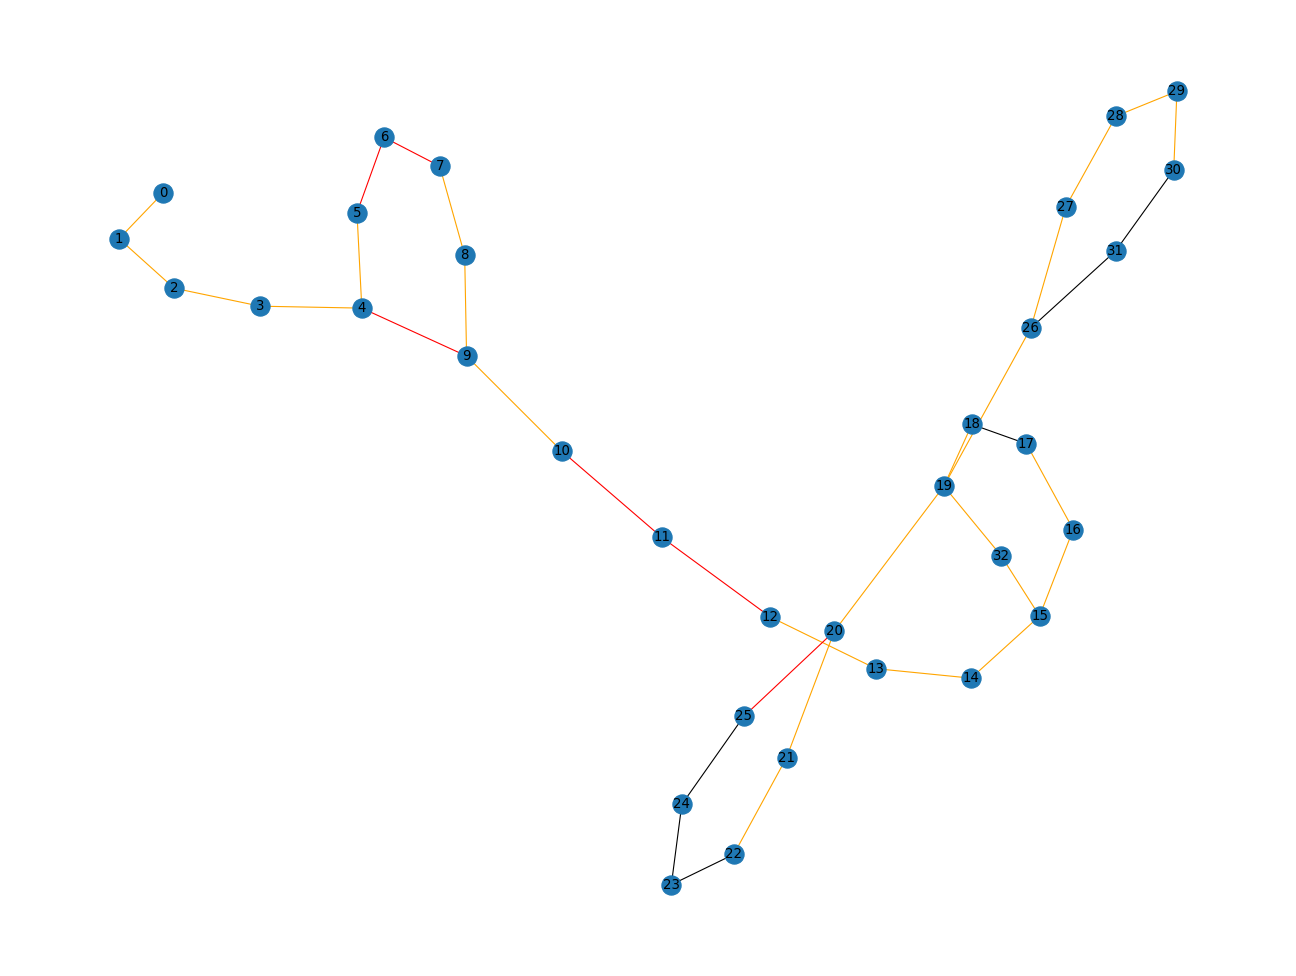

In [28]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

important_edges = np.argsort(phi_edges)
print(important_edges)
sorted_phi_edges = sorted(phi_edges, reverse = True)
print(sorted_phi_edges)
print(sum(phi_edges))

threshold = np.median(phi_edges) #to discuss when an edge in important or not
hard_edge_mask = (torch.FloatTensor(phi_edges) > threshold).to(torch.float) #>=
print(hard_edge_mask.shape)

important_edges_index = torch.nonzero(hard_edge_mask == 1)
print(important_edges_index)

edge_index = E.to(device)
important_edges_index = important_edges_index.to(device)

important_edges = torch.index_select(edge_index, dim = 1, index = important_edges_index.squeeze())
print(important_edges)

edges_color = []
mol = read_smiles(test_cpd.smiles)

#standard visualization for importan egdes GNNExplainer-like
for edge in mol.edges:
    found_from = False
    found_to = False
    for i in range(important_edges.shape[1]):
        if edge[0] == important_edges[0][i] and edge[1] == important_edges[1][i]:
            found_from = True
        if edge[1] == important_edges[0][i] and edge[0] == important_edges[1][i]:
            found_to = True
    if found_from and found_to:
        edges_color.append("red")
    elif found_from or found_to:
        edges_color.append("orange")
    else:
        edges_color.append("black")   

#visualization for indentifying unimportant edges (edge is important if both directins are above threshold)
# for edge in mol.edges:
#     found_from = False
#     found_to = False
#     for i in range(important_edges.shape[1]):
#         if edge[0] == important_edges[0][i] and edge[1] == important_edges[1][i]:
#             found_from = True
#         if edge[1] == important_edges[0][i] and edge[0] == important_edges[1][i]:
#             found_to = True
#     if found_from and found_to:
#         edges_color.append("red")
#     # elif found_from or found_to:
#     #     edges_color.append("red")
#     else:
#         edges_color.append("black")   

figure(figsize=(16, 12), dpi=80)
#mol = nx.DiGraph(mol)
labels = nx.get_node_attributes(mol, 'element') 
nx.draw(mol, with_labels = True, edge_color = edges_color, pos=nx.spring_layout(mol))
plt.savefig(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_GraphSHAPer_MC_" + str(M), dpi=300, bbox_inches='tight')
plt.show()

## GNNExplainer
Explain the classification of a test cpd using GNNExplainer

In [29]:
import os.path as osp

import torch
import torch.nn.functional as F


from torch_geometric.nn import GNNExplainer

torch.manual_seed(42)
epochs = 100
# test_cpd = test_data[0].to(device)

#model = Net().to(device)

#optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
x, edge_index, edge_weight = test_cpd.x, test_cpd.edge_index, None

explainer = GNNExplainer(model, epochs=epochs, return_type='log_prob')

node_feat_mask, edge_mask = explainer.explain_graph(x, edge_index)

Explain graph: 100%|██████████| 100/100 [00:11<00:00,  9.03it/s]


### Plot Explaination Subgraph

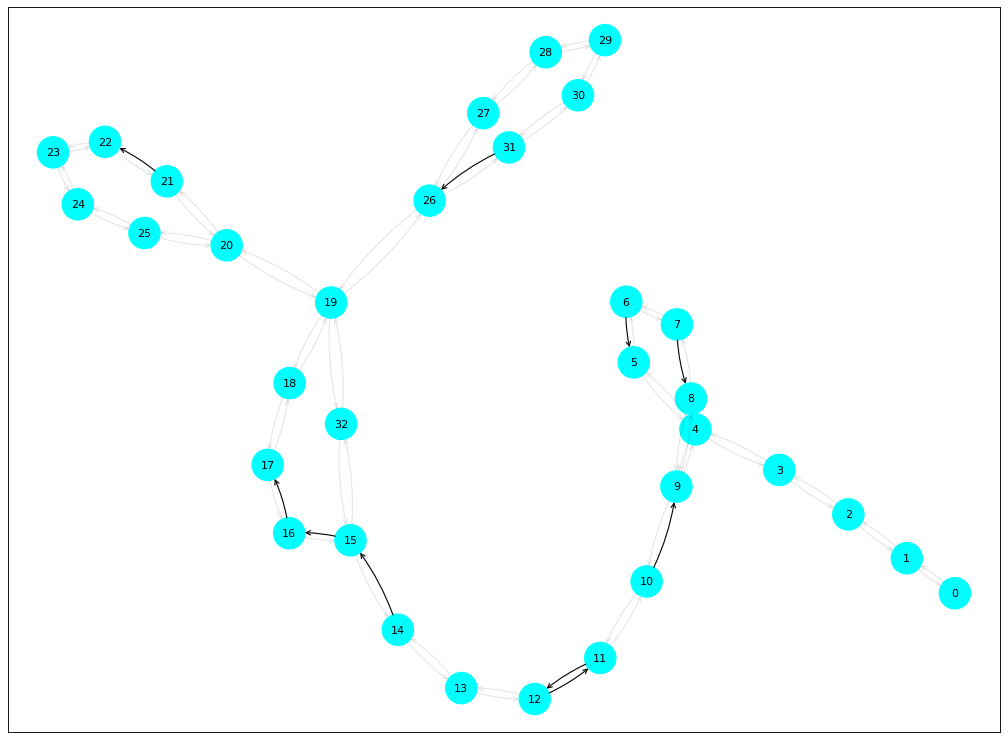

In [30]:
from matplotlib.pyplot import figure

figure(figsize=(16, 12), dpi=80)
threshold = 0.75
edge_mask = edge_mask.to("cpu")
ax, G = explainer.visualize_subgraph(edge_index = edge_index, edge_mask = edge_mask, node_idx = -1, y=None, threshold=threshold)
plt.savefig(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_GNNExplainer_viz0", dpi=300, bbox_inches='tight')
plt.show()

tensor([[12],
        [15],
        [21],
        [24],
        [25],
        [30],
        [32],
        [35],
        [48],
        [68]])
tensor([[ 6,  7, 10, 11, 12, 14, 15, 16, 21, 31],
        [ 5,  8,  9, 12, 11, 15, 16, 17, 22, 26]], device='cuda:0')


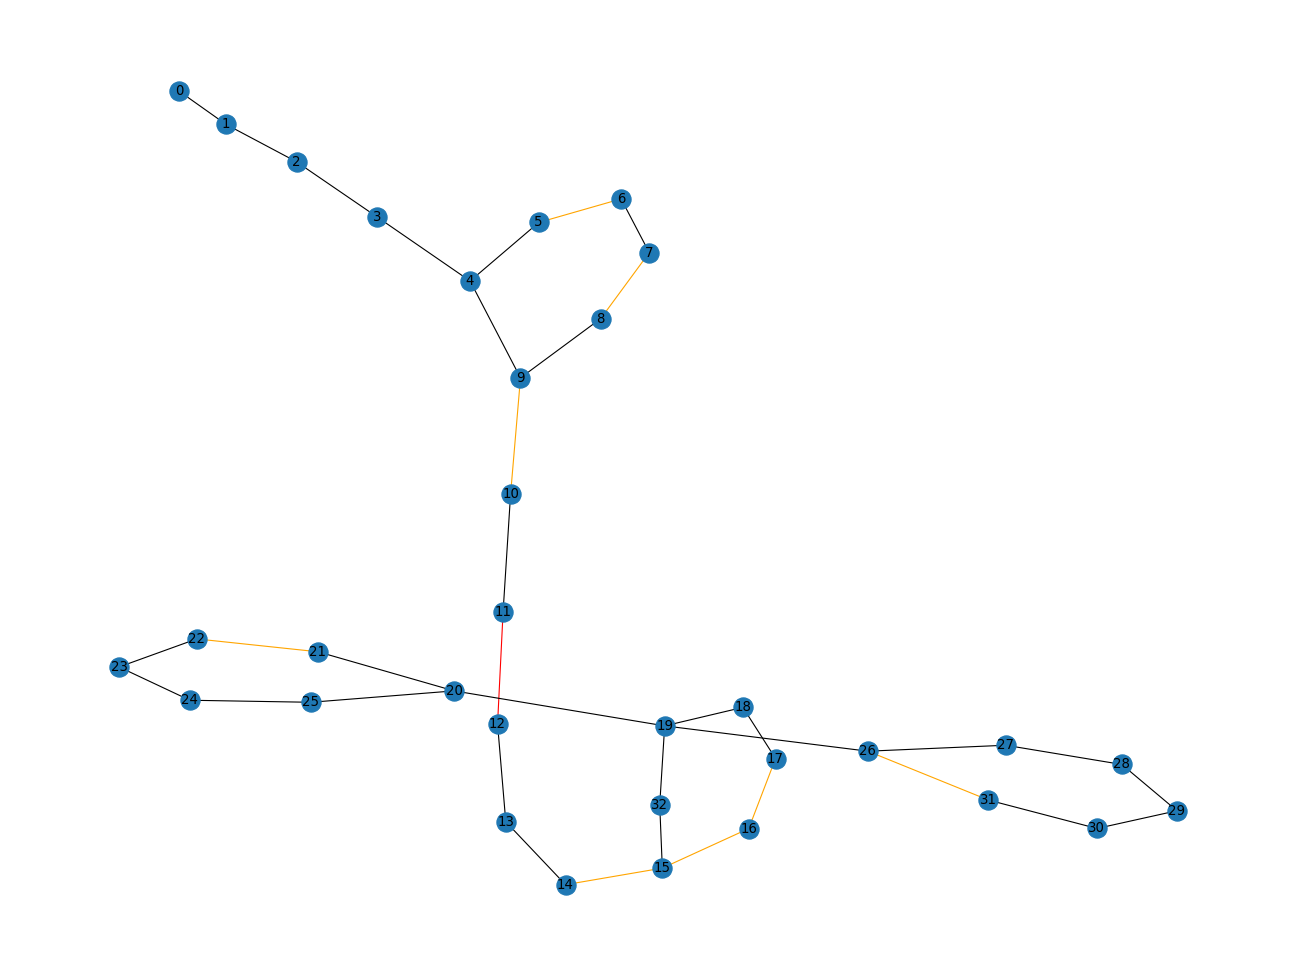

In [31]:
hard_edge_mask = (edge_mask >= threshold).to(torch.float)
hard_edge_mask.shape

important_edges_index = torch.nonzero(hard_edge_mask == 1)
print(important_edges_index)

edge_index = edge_index.to(device)
important_edges_index = important_edges_index.to(device)

important_edges = torch.index_select(edge_index, dim = 1, index = important_edges_index.squeeze())
print(important_edges)

edges_color = []
mol = read_smiles(test_cpd.smiles)

for edge in mol.edges:
    found_from = False
    found_to = False
    for i in range(important_edges.shape[1]):
        if edge[0] == important_edges[0][i] and edge[1] == important_edges[1][i]:
            found_from = True
        if edge[1] == important_edges[0][i] and edge[0] == important_edges[1][i]:
            found_to = True
    if found_from and found_to:
        edges_color.append("red")
    elif found_from or found_to:
        edges_color.append("orange")
    else:
        edges_color.append("black")   

figure(figsize=(16, 12), dpi=80)
#mol = nx.DiGraph(mol)
labels = nx.get_node_attributes(mol, 'element') 
nx.draw(mol, with_labels = True, edge_color = edges_color, pos=nx.spring_layout(mol))
plt.savefig(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_GNNExplainer_viz1", dpi=300, bbox_inches='tight')
plt.show()